# GNNExplainer

In [ ]:
import os
import hydra
import torch
import shutil
import warnings
from tqdm import tqdm
from torch.optim import Adam
from omegaconf import OmegaConf
from utils import check_dir
from gnnNets import *
from dataset import get_dataset, get_dataloader
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch_geometric.nn.models.explainer import clear_masks
import logging
import torch_geometric
import numpy as np
import captum.attr._utils.common

import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt

from dig.xgraph.evaluation import XCollector
from torch_geometric.nn import GNNExplainer

from torch_geometric.nn.models.explainer import (
    Explainer,
    clear_masks,
    set_masks,
)

from rdkit import Chem
from torch_geometric.data import Data
from visualize import visualize_attrs
from dig.xgraph.dataset.mol_dataset import *

from time import sleep

from PIL import Image
import pylab as pl

: 

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="config", job_name="test_app")
cfg = compose(config_name="config", overrides=[])
print(OmegaConf.to_yaml(cfg))


models:
  gnn_saving_dir: ''
  gnn_name: gat
  n_heads: 3
  param:
    clintox:
      learning_rate: 0.0005
      weight_decay: 0.0005
      milestones: None
      gamma: None
      batch_size: 64
      num_epochs: 200
      num_early_stop: 0
      gnn_latent_dim:
      - 64
      - 64
      - 64
      gnn_dropout: 0.0
      add_self_loop: true
      gcn_adj_normalization: false
      gnn_emb_normalization: false
      graph_classification: true
      node_classification: false
      gnn_nonlinear: sigmoid
      readout: sum
      fc_latent_dim:
      - 128
      fc_dropout: 0.0
      fc_nonlinear: elu
    tox21:
      learning_rate: 0.001
      weight_decay: 0.0005
      milestones: None
      gamma: None
      batch_size: 64
      num_epochs: 200
      num_early_stop: 20
      gnn_latent_dim:
      - 128
      - 128
      - 128
      gnn_dropout: 0.0
      add_self_loop: true
      gcn_adj_normalization: true
      gnn_emb_normalization: false
      graph_classification: true
      n

/home/michelaproietti/.conda/envs/thesis/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
config = cfg

In [4]:
config.models.gnn_saving_dir = 'gnn_checkpoints'
config.models.param = config.models.param[config.datasets.dataset_name]

if torch.cuda.is_available():
    device = torch.device('cuda', index=config.device_id)
else:
    device = torch.device('cpu')

dataset = get_dataset(dataset_root=config.datasets.dataset_root,
                      dataset_name=config.datasets.dataset_name)
dataset.data.x = dataset.data.x.float()
dataset.data.y = dataset.data.y.squeeze().long()
if config.models.param.graph_classification:
    dataloader_params = {'batch_size': 1,
                         'stratified': config.stratified,
                         'random_split_flag': config.datasets.random_split_flag,
                         'data_split_ratio': config.datasets.data_split_ratio,
                         'seed': config.datasets.seed}

In [5]:
dataset = get_dataset(dataset_root=config.datasets.dataset_root,
                          dataset_name=config.datasets.dataset_name)

In [6]:
dataloader = get_dataloader(dataset, **dataloader_params)

In [13]:
model = get_gnnNets(dataset.num_node_features, dataset.num_classes, config.models, config.concept_whitening, concept_acts=True)
model.replace_norm_layers()

In [14]:
saved = torch.load(f"./trained_models/bbbp/{config.models.gnn_name}_cw_max.pth")
state_dict = saved['net']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
gnn_explainer = GNNExplainer(model, epochs=100, lr=0.01, explain_graph=True, allow_edge_mask=config.models.gnn_name!='gcn', return_type='log_prob', feat_mask_type='scalar', log=False)
gnn_explainer._to_log_prob = lambda x: x[0].mean(axis=0)[3].reshape((1,1))
x_collector = XCollector()

In [16]:
clear_masks(model)

Linear(in_features=128, out_features=2, bias=True)

In [7]:
def data_from_smiles(smiles, y):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        x.append(x_map['chirality'].index(str(atom.GetChiralTag())))
        x.append(x_map['degree'].index(atom.GetTotalDegree()))
        x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
        x.append(x_map['num_radical_electrons'].index(
            atom.GetNumRadicalElectrons()))
        x.append(x_map['hybridization'].index(
            str(atom.GetHybridization())))
        x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(x_map['is_in_ring'].index(atom.IsInRing()))
        xs.append(x)

    x = torch.tensor(xs, dtype=torch.long).view(-1, 9)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    # Sort indices.
    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,
                smiles=smiles, mol=mol)
    
    return data

2039
1
10
102
117
135
15
22
23
27
28
31
49


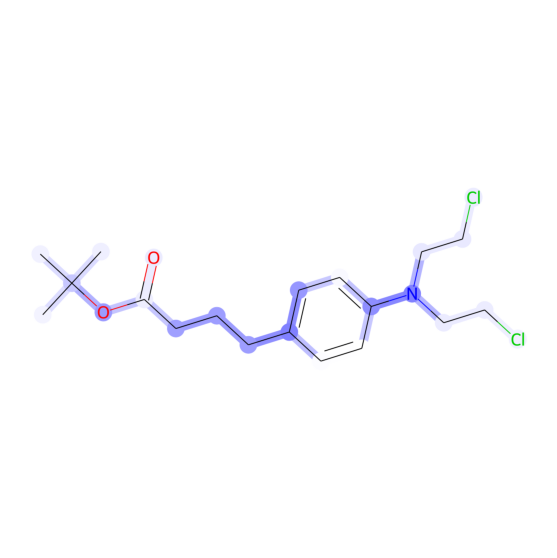

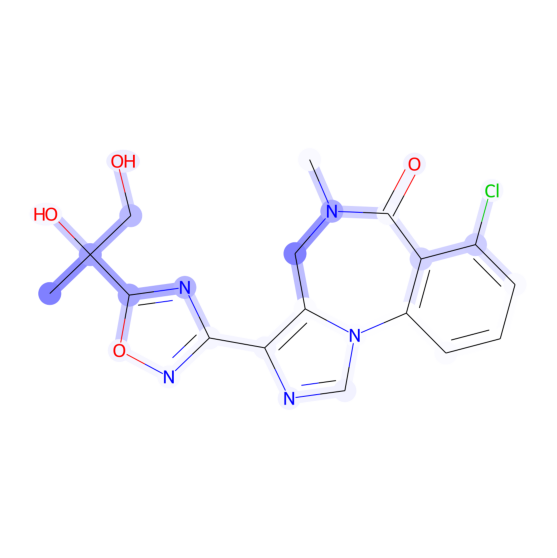

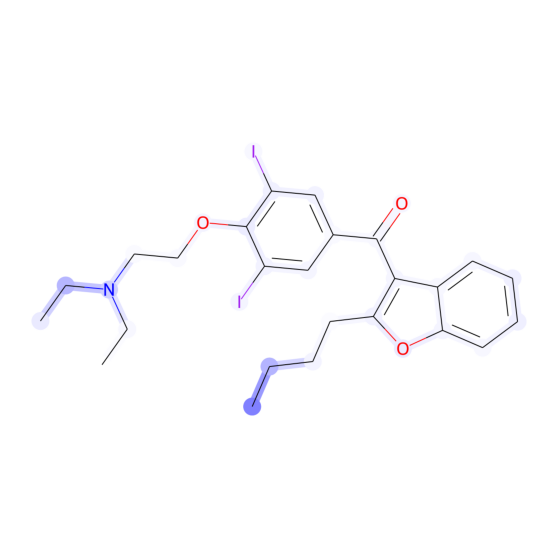

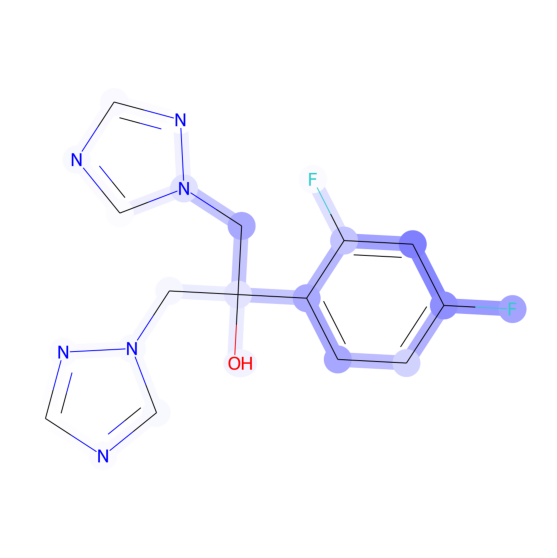

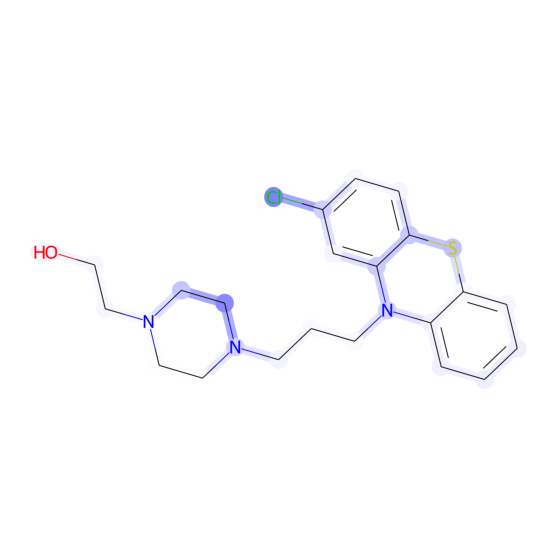

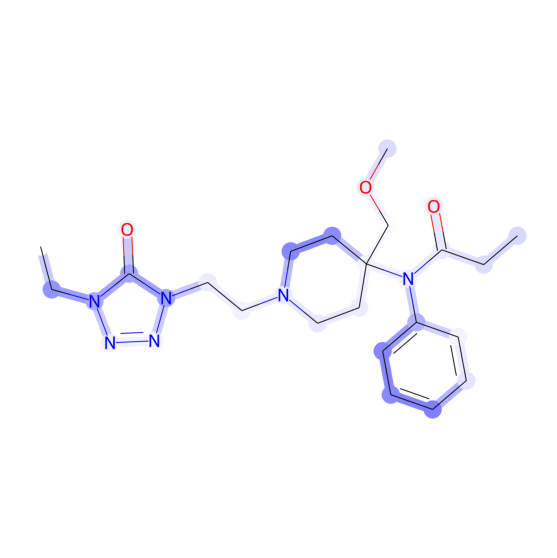

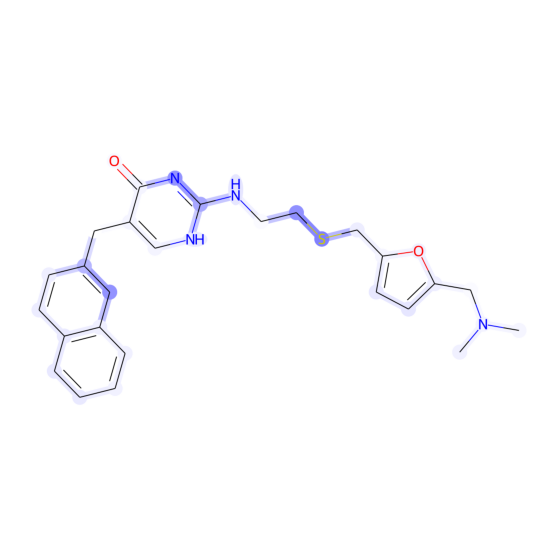

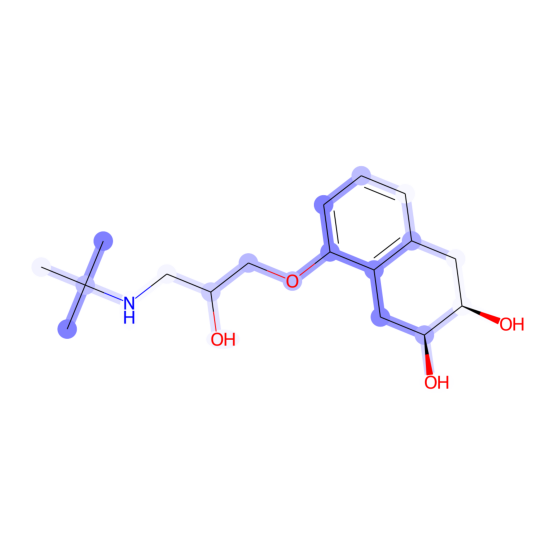

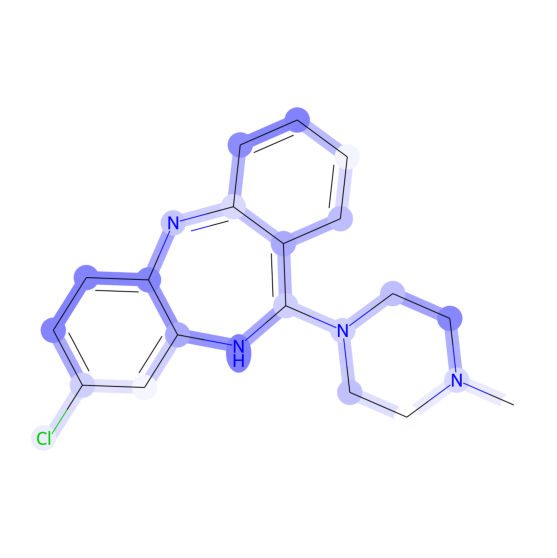

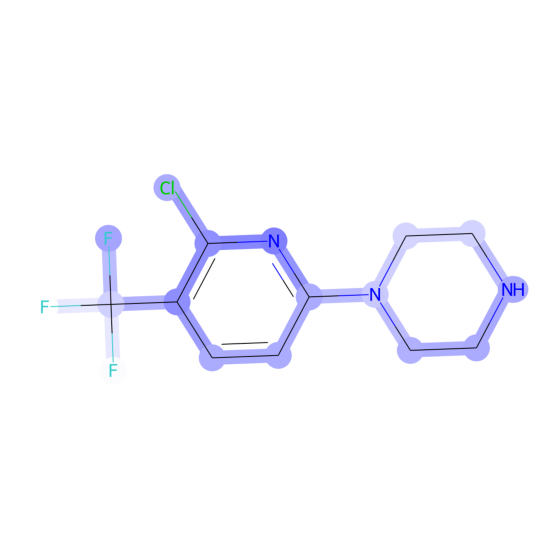

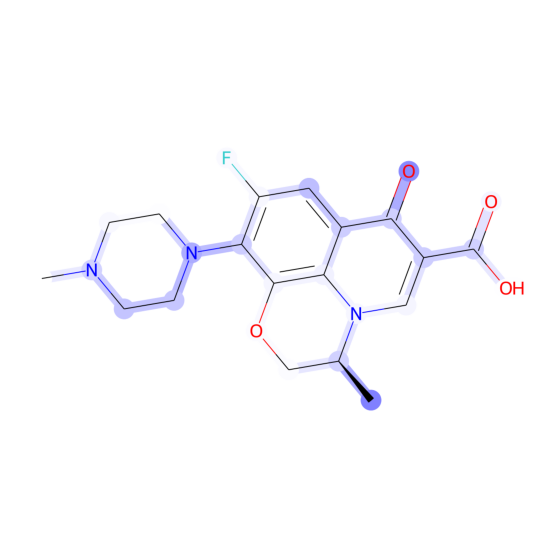

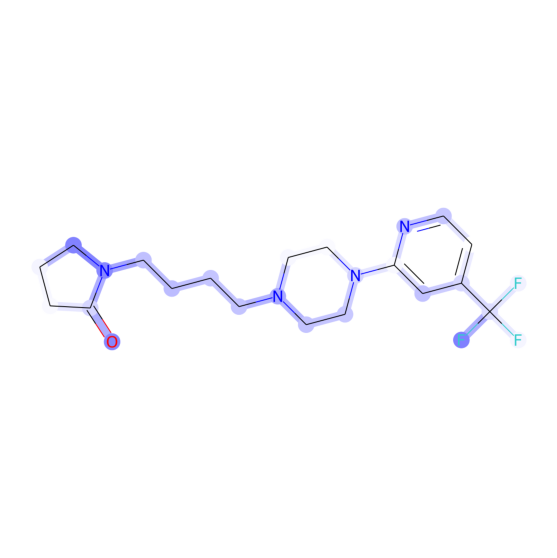

In [37]:
dst = './plot/bbbp_nocount_1/'
if not os.path.exists(dst):
        os.mkdir(dst)

# Choose molecules
l = [dataset[1], dataset[10],dataset[102],dataset[117],dataset[135],dataset[15],dataset[22],dataset[23],dataset[27],dataset[28],dataset[31],dataset[49]]
indexes = [1,10,102,117,135,15,22,23,27,28,31,49]

print(len(dataset))
for index, data in zip(indexes,l):
    print(index)
    
    data.x = data.x.float()
    
    data_new = data_from_smiles(data.smiles, data.y)
    data_new.x = data_new.x.float()
    
    node_feat_mask, edge_mask = gnn_explainer.explain_graph(data_new.x, data_new.edge_index)
    
    attrs = torch.ones(data_new.x.shape[0])

    for i in range(data_new.x.shape[0]):
        l = []
        for e in range(data_new.edge_index.shape[1]):
            if config.models.gnn_name == 'gcn':
                if data_new.edge_index[0,e] == i:
                    l.append(node_feat_mask[data_new.edge_index[1,e]])
                elif data_new.edge_index[1,e] == i:
                    l.append(node_feat_mask[data_new.edge_index[0,e]])
            else:
                if data_new.edge_index[0,e] == i or data_new.edge_index[1,e] == i:
                    l.append(edge_mask[e])

        attrs[i] = sum(l) / (len(l)+1e-6)
        
    attrs = (attrs - attrs.min()) / (attrs.max() - attrs.min())

    img = visualize_attrs(data_new.mol, -attrs.numpy(), size=1200)

    fig = plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.axis('off')
    plt.savefig('{}{}_{}.jpg'.format(dst, config.datasets.dataset_name, index), dpi=600)
    
    index += 1

In [20]:
dst = './plot/bbbp_nocount_1/'

img1 = Image.open(dst+f'{config.datasets.dataset_name}_1.jpg')
img2 = Image.open(dst+f'{config.datasets.dataset_name}_10.jpg')
img3 = Image.open(dst+f'{config.datasets.dataset_name}_102.jpg')

(-0.5, 5999.5, 5999.5, -0.5)

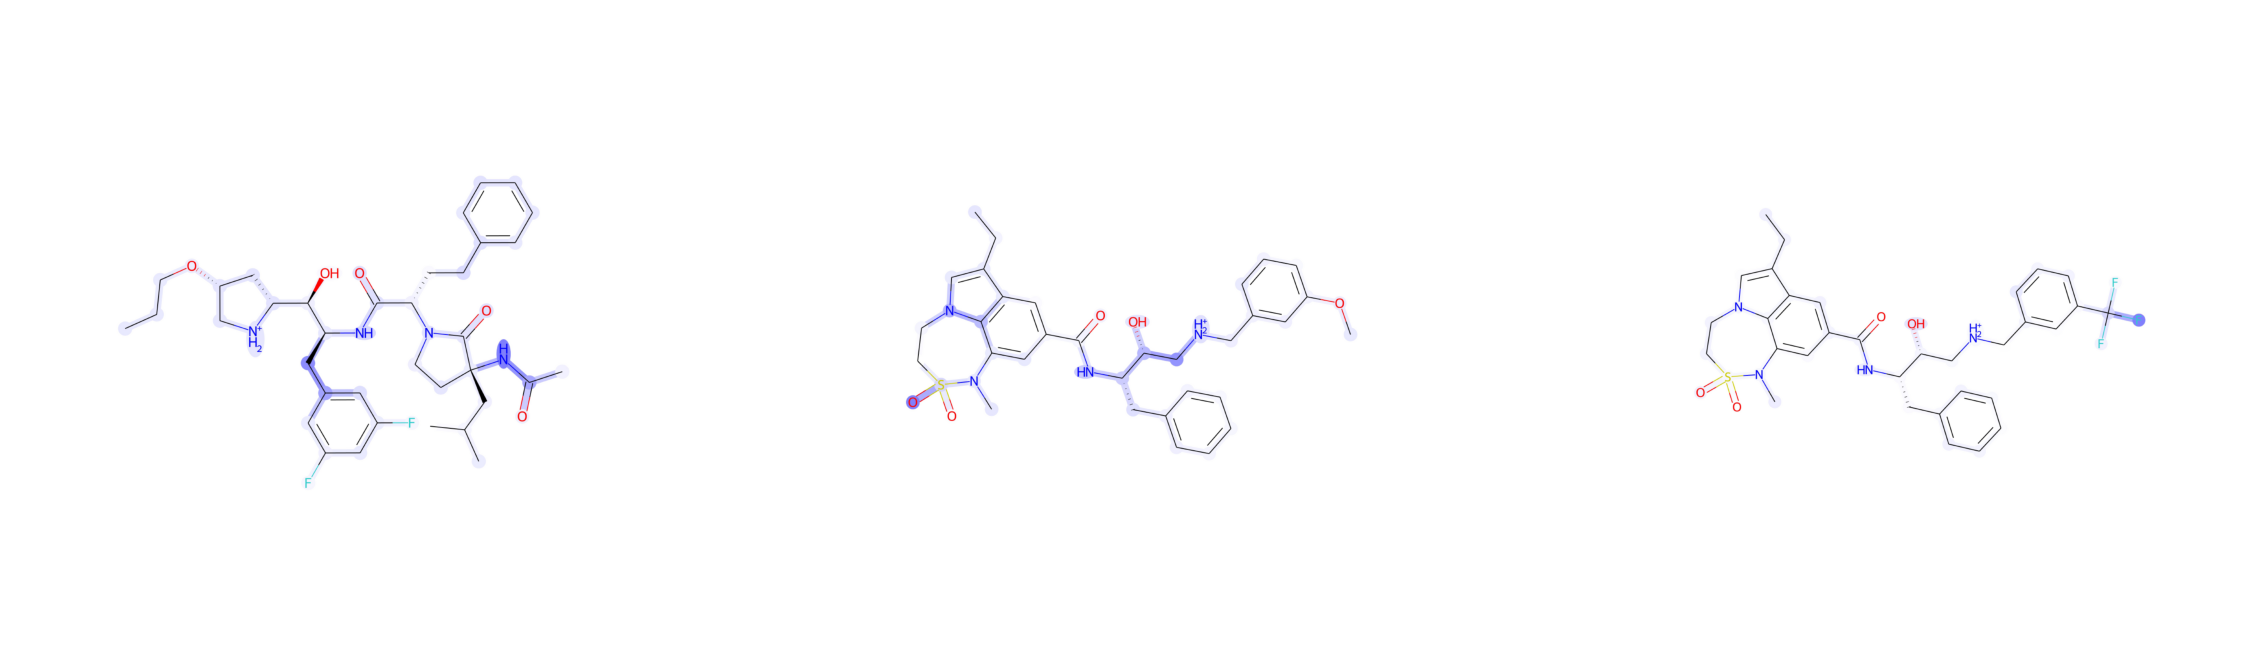

In [21]:
fig = plt.figure(figsize=(40,15))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.axis ('off')

plt.subplot(1,3,2)
plt.imshow(img2)
plt.axis ('off')

plt.subplot(1,3,3)
plt.imshow(img3)
plt.axis ('off')

## Examples of molecules from the dataset

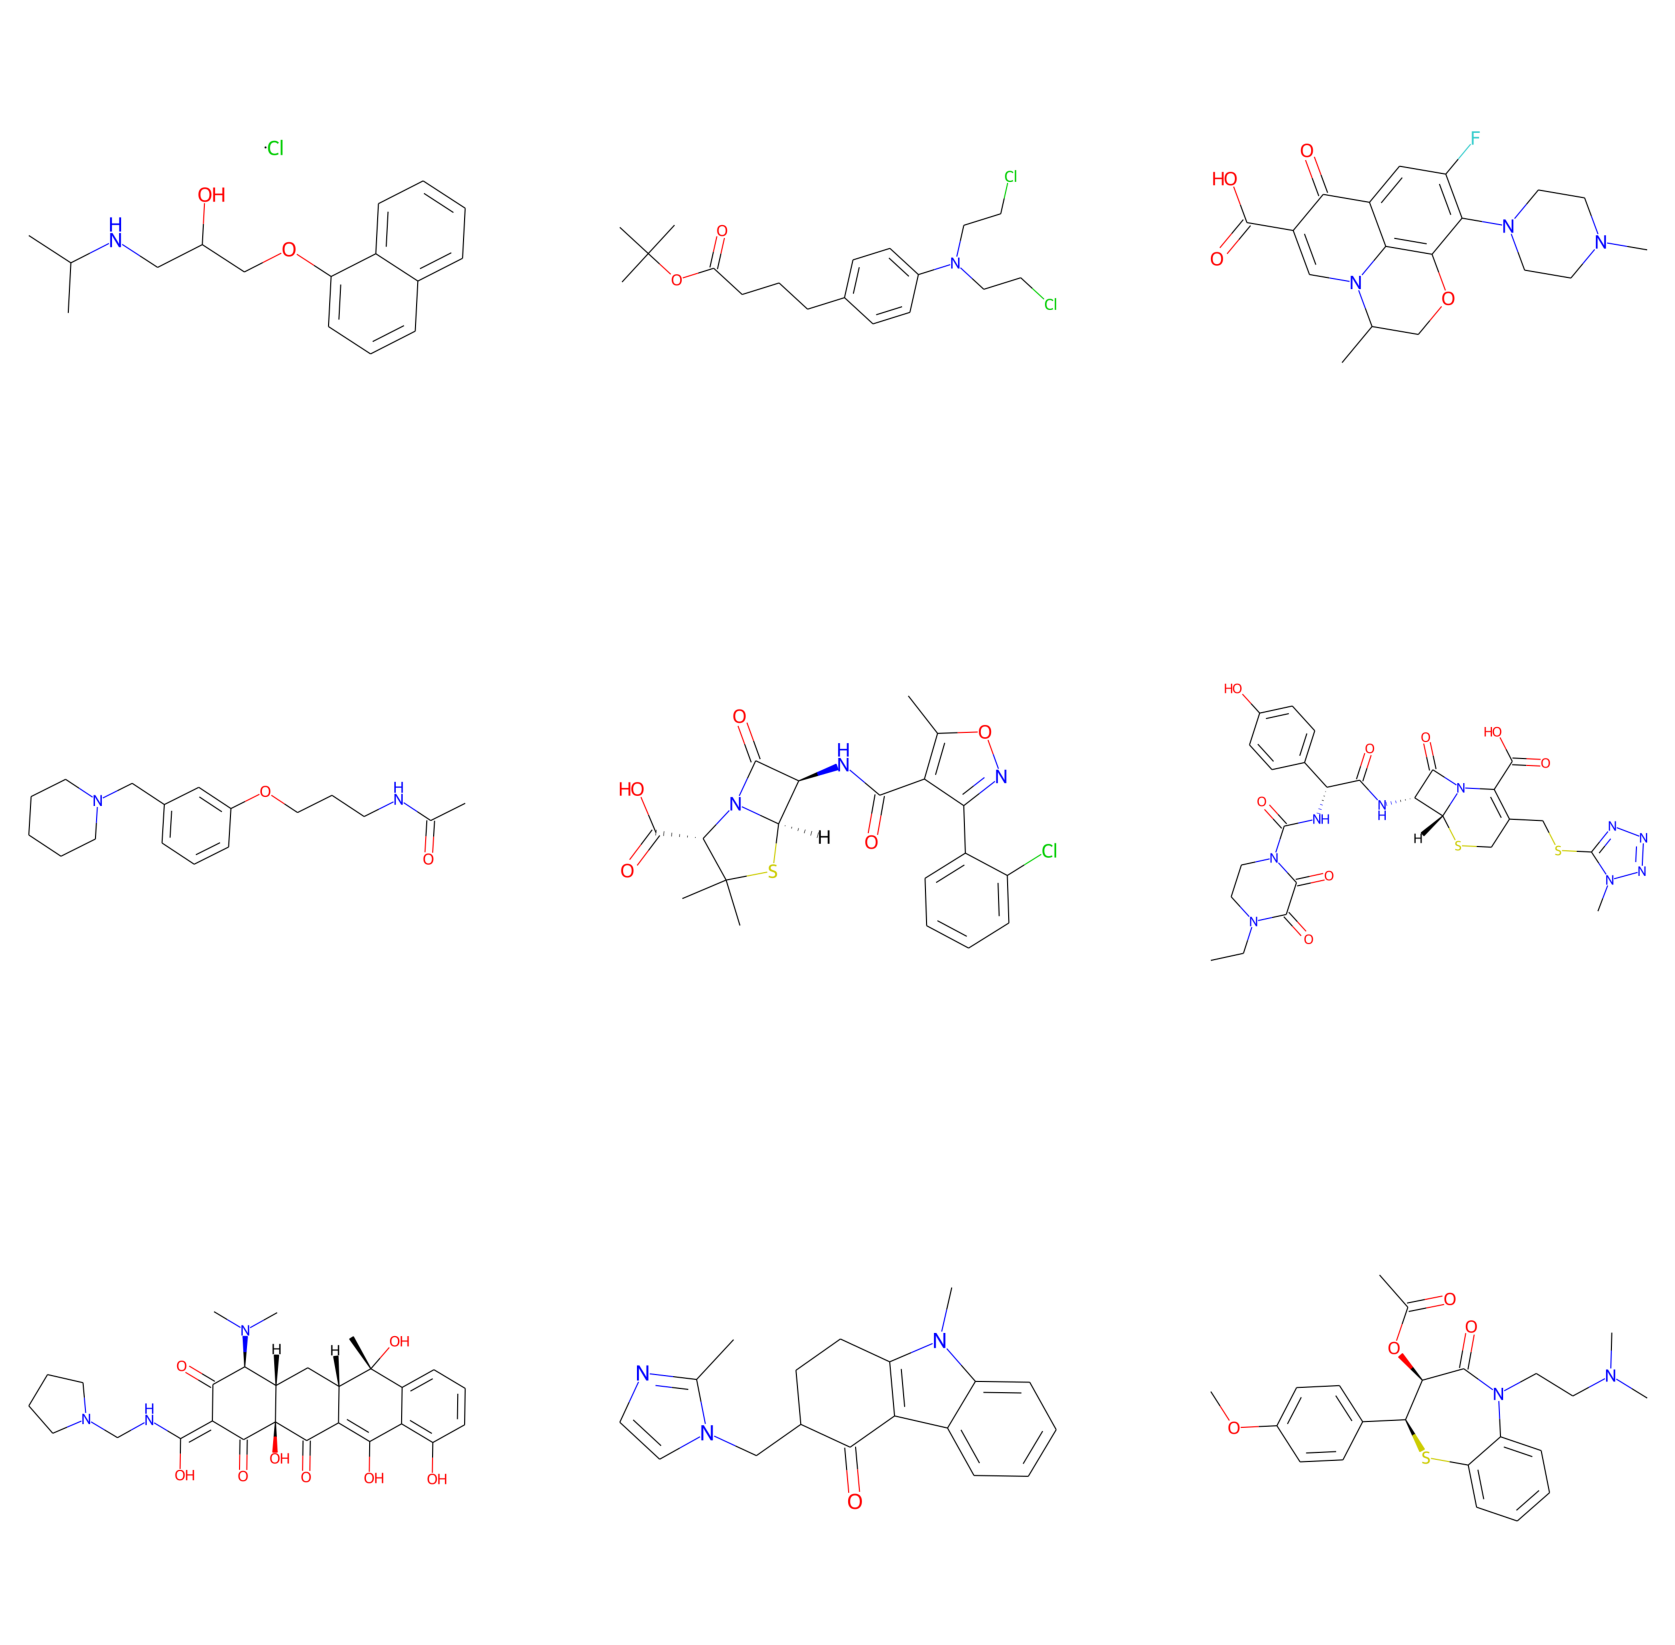

In [12]:
from rdkit.Chem import Draw

fig = plt.figure(figsize=(30,30))

for i,data in enumerate(dataset[:9]):
    data_new = data_from_smiles(data.smiles, data.y)
    img = Draw.MolToImage(data_new.mol, size=(900,900))
    
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')